In [1]:
from multiprocessing import Pool
import multiprocessing
import worker
from timeit import default_timer as timer

In [4]:
__name__

'__main__'

In [5]:
if __name__=='__main__':
    num_processors = 4
    p=Pool(processes = num_processors)
    output = p.map(worker.worker, [i for i in range(0,3)])
    print(output)

[0, 1, 4]


In [8]:
multiprocessing.cpu_count()

4

In [4]:
#Create sizes for 3 arrays. 
sizes = [100 * 10**6 for i in range(0,3)] #Size of each array is 5 million here.
#Applying the function sequentially
tic = timer()
[worker.createandsort(size) for size in sizes]
tac = timer()
print("time for sequential sorting: ", tac-tic)
#Using multiprocessing
if __name__ == "__main__":
    pool = Pool(processes=3)
    tic = timer()
    pool.map(worker.createandsort,sizes)
    tac = timer()
    print("time for parallel sorting: ",tac-tic)

time for sequential sorting:  37.572133799999996
time for parallel sorting:  17.4616884


In [23]:
import utils as ut
import pickle

In [83]:
class DataHandler():
    # Takes output of worm trials and formats/stores for model and agent use.
    # Tries to ensure that a matching parameters dictionary has been saved with each df. 
    def __init__(self):
        self.clear_df()

    def add_dict_to_df(self,fnames,**kwargs):
        # Takes fnames as a list.
        # kwargs are the arguments that would go to make_df() in utils.
        # Can run this when self.df is empty or exists. If exists, then adds to existing df.
        for key,val in kwargs.items():
            self.params[key] = val 
        if len(kwargs)==0:
            print('No kwargs')
            kwargs = self.params 
        
        self.df = ut.make_df(fnames, old_frame=self.df, **kwargs)

    def add_df_to_df(self,fnames):
        # Takes fnames as list
        for fname in fnames:
            with open(fname,'rb') as f:
                self.df = self.df.append(pickle.load(f), ignore_index=True)

    def load_df(self,fname):
        with open(fname,'rb') as f:
            self.df = pickle.load(f)
        with open(fname[:-4]+'_params.pkl','rb') as f:
            self.params = pickle.load(f) 
        
    def clear_df(self):
        self.df = None 
        self.params = {
            'reward_ahead': None,
            'timestep_gap': None,
            'prev_act_window': None,
            'jump_limit': None,
        }

    def save_dfs(self,fname):
        self.df.to_pickle(fname) 
        with open(fname[:-4]+'_params.pkl','wb') as f:
            pickle.dump(self.params, f)
    
    def __str__(self):
        if self.df is None:
            return f'No dataframe\nParams are {self.params}'
        return f'Len of dataframe is {len(self.df)}\nParams are {self.params}'

In [84]:
dh = DataHandler()

In [85]:
dh.load_df('./tester.pkl')

In [86]:
dh.df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.140,-150,-120,3,30,-30,-0.737374,"[848.3, 1068.0]"
2,1.312,30,-30,3,150,-60,-1.857143,"[848.25, 1068.0]"
3,1.500,150,-60,2,150,-60,1.714286,"[847.8333333333334, 1068.1666666666667]"
4,1.672,150,-60,1,150,150,-0.033333,"[848.0, 1068.125]"
...,...,...,...,...,...,...,...,...
39805,90.953,-60,30,0,-60,0,4.704910,"[814.4888888888889, 1163.388888888889]"
39806,91.907,-60,-30,0,120,-30,5.685787,"[818.0493827160494, 1161.0246913580247]"
39807,92.860,120,-30,3,-60,60,7.252035,"[821.0114942528736, 1158.528735632184]"
39808,93.797,30,-30,0,30,-30,6.106920,"[823.471264367816, 1154.0344827586207]"


In [78]:
dh.add_dict_to_df(['./Data/traj02-11-2020_15-43-12.pkl'],timestep_gap=100)

In [1]:
import ensemble_mod_env as eme
import model_based_agent as mba
import numpy as np
import utils as ut
import matplotlib.pyplot as plt

In [2]:
dh = mba.DataHandler()
dh.load_df('./nogap_traj_df.pkl')
modset = eme.ModelSet(10,frac=.5)

In [3]:
modset.make_models(dh, sm_pars={'lambda':.05,'iters':30})

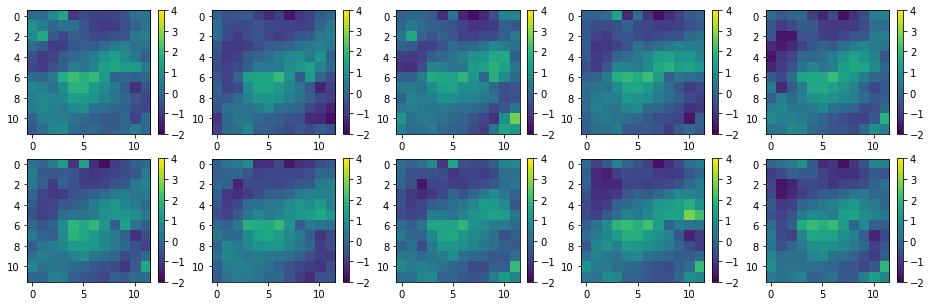

In [4]:
fig,ax = plt.subplots(2,5)
fig.set_size_inches((16,5))
for i in range(10):
    img = ax[i//5,i%5].imshow(modset.models[i]['reward_off'][:,:,0],vmin=-2,vmax=4)
    fig.colorbar(img, ax=ax[i//5,i%5]);

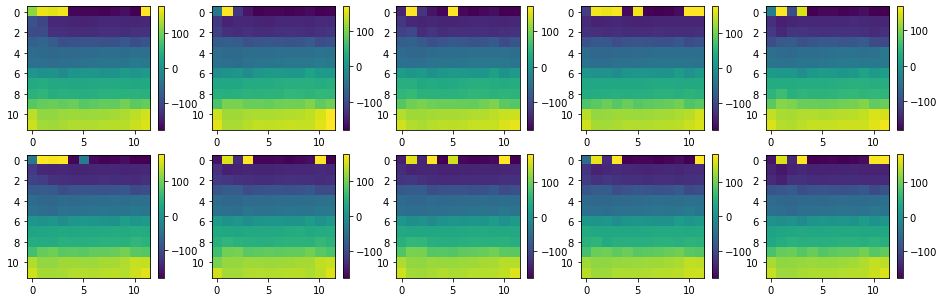

In [5]:
fig,ax = plt.subplots(2,5)
fig.set_size_inches((16,5))
for i in range(10):
    img = ax[i//5,i%5].imshow(modset.models[i]['body_off'][:,:,0])
    fig.colorbar(img, ax=ax[i//5,i%5]);

In [6]:
worm = eme.FakeWorm(modset)

In [48]:
obs,rew, done, _ = worm.step(0)

In [49]:
worm.obs2grid(obs)

array([ 60, -30])